<a href="https://colab.research.google.com/github/MariaSparrow/HSE_CS/blob/main/HW_cs_march_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание № 3 Построение заявочной скоринговой модели
**Общая информация:**
- ⚡Дата выдачи: 14 марта 2023
- ⏰ Мягкий дедлайн 23:59MSK 27.03.2023
- ⏰ Жесткий дедлайн 23:59MSK 30.03.2023
- ✍ работы должны быть высланы на почту maria.vorobyova.ser@gmail.com с темой HSE_CS_[направление]_ФИО, например HSE_CS_ПАД_ИВАНОВ_ИВАН_ИВАНОВИЧ

**Оценивание и штрафы:**

Максимальный балл за работу — 10 баллов. За каждый день просрочки снимается 1 балл. После жесткого дедлайна сдача невозможна. 

Задание должно быть выполнено самостоятельно, «похожие» решения будут рассмотрены как "плагиат" и все похожие работы будут оценены баллом 0.

_Оценка будет снижена, если_ 
- нет комментариев 
- код написан плохо, непонятно
- сделаны неверные выводы

**Что нужно сделать?**

Необходимо построить модель, оценивающую вероятность дефолта клиента на стадии заведения кредитной заявки. Идти нужно строго по ноутбуку и выполнять задания каждого блока.

Перед началом выполнения работы необходимо скачать 2 датасета:
 - Данные с одобренными кредитными заявками [датасет](https://drive.google.com/file/d/1YUEMYCmvLs786AyIUV4l4NZg6k4Sb1cj/view?usp=share_link)
 - Данные с отказанными кредитными заявками [датасет](https://drive.google.com/file/d/1Q1YS4HKJVkTkIRTQsxSzutuKiM5mxUqx/view?usp=share_link)

Описание датасета:

1. target - целевая переменная (1- клиент достиг просрочку 90 дней в первый год кредита, 0 - иначе)
2. INCOME_TYPE - тип подтверждения дохода                
3. EDUCATION_  -  образование               
4. CUSTOMER_CATEGORY_  - категория клиента         
5. income   - доход клиента                  
6. DEPENDANT_NUMBER   - количество иждевенцев         
7. IS_EMPL    - это сотрудник банка                  
8. COUNT_ACTIVE_CREDIT_NO_CC  - количество октрытых кредитов без учета кредитных карт
9. CNT_MNTH_FROM_LAST_PMNT    - сколько месяцев прошло с момента последнего платежа по предудущему кредиту
10. age  - возраст клиента                     
11. experience  - стаж клиента               
12. inquiry_14_day   - количество запросов в бюро кредитных историй за последние 14 дней          
13. inquiry_21_day   - количество запросов в бюро кредитных историй за последние 21 день                  
14. count_mnth_act_passport - сколько месяцев прошло с момента выдачи выдачи паспорта     
15. UID  - ID заявки    

Желаем вам удачи!✌

Ссылка на слайды [семинара](https://drive.google.com/file/d/18ox08w_016lopYZYu248Z6HHcYytsvus/view?usp=sharing), ноутуб к [семинара](https://colab.research.google.com/drive/1cTeBStjzws0Xo3pLaC3YtF1X1lZq85WK?usp=sharing) 

In [2175]:
# import библиотек
import pandas as pd
import numpy as np

from copy import copy

# чтобы отобразить больше столбцов и строк
# pd.options.display.max_rows = 50
pd.options.display.max_columns = 200

import warnings
warnings.filterwarnings('error')


# для работы с датами, временем
from datetime import timedelta
import datetime as dt

# для построения графиков
import matplotlib.pyplot as plt
# %matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]
import seaborn as sns


from IPython.display import display, HTML, display_html
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

In [2176]:
# считать данные
accept = pd.read_csv('accept.csv')
reject = pd.read_csv('reject.csv')

In [2177]:
accept.sample(5)

,target,INCOME_TYPE,EDUCATION_,CUSTOMER_CATEGORY_,income,DEPENDANT_NUMBER,IS_EMPL,COUNT_ACTIVE_CREDIT_NO_CC,CNT_MNTH_FROM_LAST_PMNT,age,experience,inquiry_14_day,inquiry_21_day,count_mnth_act_passport,UID
17362,0,OTHER,high,NaN,52000.0,0.0,0,0.0,11.155108,53.698630,2.219178,0.0,1.0,8.517067,76932
10597,0,2NDFL,elementary,NaN,40608.0,0.0,0,1.0,0.605309,29.608219,1.317808,1.0,1.0,6.200000,47290
12090,0,OTHER,high,Corporate,34943.0,0.0,1,1.0,0.606877,36.583300,14.454795,1.0,1.0,10.200000,53816
16112,0,OTHER,elementary,Corporate,17452.0,0.0,1,NaN,NaN,25.175380,0.440407,NaN,NaN,1.468493,71444
31302,0,OTHER,elementary,Corporate,19878.0,0.0,0,1.0,-1.007325,28.063014,0.621918,1.0,3.0,7.339726,138418


In [2178]:
reject.sample(5)

,INCOME_TYPE,EDUCATION_,CUSTOMER_CATEGORY_,income,DEPENDANT_NUMBER,IS_EMPL,COUNT_ACTIVE_CREDIT_NO_CC,CNT_MNTH_FROM_LAST_PMNT,age,experience,inquiry_14_day,inquiry_21_day,count_mnth_act_passport,UID
7043,OTHER,elementary,Corporate,17689.0,0.0,1,0.0,0.855332,24.180328,0.549180,0.0,1.0,3.132510,96755
889,OTHER,high,Corporate,42839.0,0.0,1,0.0,0.986111,24.308743,2.711296,0.0,0.0,4.254098,11495
4131,OTHER,elementary,Corporate,26105.0,0.0,1,1.0,1.636761,24.686533,2.302972,0.0,0.0,4.546807,57749
1985,OTHER,elementary,Corporate,28543.0,0.0,1,NaN,NaN,23.666667,0.785036,NaN,NaN,3.655738,26733
2754,OTHER,elementary,Corporate,47237.0,0.0,1,0.0,0.336918,23.619178,0.463014,1.0,1.0,2.679452,37980


In [2179]:
accept_train, accept_test = train_test_split(accept, test_size=0.2, random_state=42)

# Explatory Data Analysis. Максимально - 2 балла

- 0 баллов, если задание не выполнено
- 1 балл, если посчитаны статистики,есть какие-то графики (важно, ПОЛЕЗНЫЕ графики), но не сделаны выводы
- 2 балла, если посчитаны статистики и есть графики (важно, ПОЛЕЗНЫЕ графики) и сделаны ВЫВОДЫ (важно, что выводы правильные)

посмотрим на распределение таргета в данных

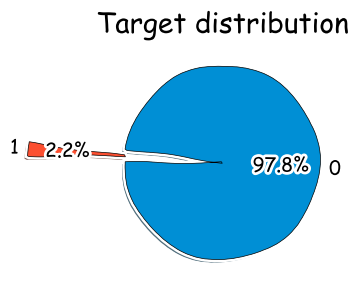

In [2180]:
plt.figure(figsize=(3,3))
plt.style.use('fivethirtyeight')
plt.xkcd()

slices = accept_train.target.value_counts()
labels = accept_train.target.value_counts().reset_index()['index']
explode = accept_train.target.value_counts().reset_index()['index']

plt.pie(slices,
        labels=labels,
        explode=explode, 
        shadow=True,
        startangle=180, 
        autopct='%1.1f%%',
        wedgeprops={'edgecolor':'black'}
        )


plt.title('Target distribution')
plt.show()

у нас подавляющее большинство таргета – нули, так что нужно быть аккуратными с подсчетами метрик, которые это не учитывают. ведь если у нас моделька будет банально выдавать константное предсказание нуля, то какой-нибудь accuracy будет почти 98 процентов, что на самом деле не будет говорить о хорошем качестве модели. будем об этом помнить дальше

теперь по описанию признаков в самом начале ноутбука разделю их на числовые и категориальные. убрала столбец UID, потому что его можно в любую категорию поместить + проверим его отдельно

In [2181]:
categorical = ['INCOME_TYPE', 'EDUCATION_', 'CUSTOMER_CATEGORY_', 'IS_EMPL']
numerical = ['income', 'DEPENDANT_NUMBER', 'COUNT_ACTIVE_CREDIT_NO_CC', 
             'CNT_MNTH_FROM_LAST_PMNT', 'age',  'experience', 'inquiry_14_day',
             'inquiry_21_day', 'count_mnth_act_passport']

как и обещала, сначала проверим, нет ли каких-то повторений в UID в общей выборке (без разделения на train и test), а то вдруг у нас некорректно как-то с дубликатами данные выгрузились

In [2182]:
assert(accept['UID'].duplicated().sum() == 0)

но все ок. теперь поглядим на разные категориальные признаки, какие там бывают значения, в каких количествах

In [2183]:
def show_values(categories, data):
    stylers = []
    for category in categorical:
        if category in categories:
            stylers.append(data[category].value_counts(dropna=False).to_frame().style.set_table_attributes("style='display:inline'"))
    
    displayers = stylers[0]._repr_html_()
    for i in range(1, len(stylers)):
        displayers += "\xa0" * 10 + stylers[i]._repr_html_()
    
    display_html(displayers, raw=True)

In [2184]:
show_values(categorical, accept_train)

,INCOME_TYPE
OTHER,17499
2NDFL,8544
,EDUCATION_
elementary,17088
advanced,6802
beginner,1175
high,978
,CUSTOMER_CATEGORY_
nan,15560
Corporate,10165


заметим, что у нас нигде нет нанов кроме CUSTOMER_CATEGORY_, их там очень много, больше половины, и, кажется, это вряд ли означает реальный пропуск, мол забыли указать, что это вип клиент :) мне кажется, это просто самые обычные клиенты: не корпоративные и не вип, так что я бы эти наны заменила на категорию "regular"

In [2185]:
# сделала специальную функцию, которая будет применять аналогичные изменения и train, и test датасетам, 
# чтобы не было дублирований в коде. будем эту функцию использовать и дальше
def apply(datasets, function):
    result = list()
    for dataset in datasets:
        result.append(function(dataset))
    return result

In [2186]:
def make_regular_cutomer_category(data):
    indexes = data['CUSTOMER_CATEGORY_'].isna()
    data.loc[indexes, 'CUSTOMER_CATEGORY_'] = 'Regular'
    return data

In [2187]:
accept_train, accept_test = apply([accept_train, accept_test], make_regular_cutomer_category)

In [2188]:
show_values(categorical, accept_train)

,INCOME_TYPE
OTHER,17499
2NDFL,8544
,EDUCATION_
elementary,17088
advanced,6802
beginner,1175
high,978
,CUSTOMER_CATEGORY_
Regular,15560
Corporate,10165


теперь посчитаем разные статистики по числовым признакам, чтобы иметь какое-то общее представление о данных

In [2189]:
# функция для подсчета статистик: количество и процент уникальных значений, нулей и нанов, 
# а так же минимума, максимума, среднего, стандартного отклонения и медианы
def stats(df):
    no_nans = []
    nans = []

    rows = df.shape[0]

    stats = pd.DataFrame(columns=['data type', 'unique values', 'unique %',
                                  'null value', 'null %', 'nan value', 'nan %',
                                  'min', 'max', 'mean', 'standart deviation', 'median'])

    for column in df.columns:
        unique = len(df[column].unique())
        unique_percent = unique / rows * 100
        
        nan = df[column].isna().sum()
        nan_percent = nan / rows * 100
        
        zeros = (df[column] == 0).sum()
        zeros_percent = zeros / rows * 100
        
        stats.loc[column] = [
            df[column].dtype,
            unique, unique_percent,
            zeros, zeros_percent,
            nan, nan_percent,
            df[column].min(),
            df[column].max(),
            df[column].mean(),
            df[column].std(),
            df[column].median()
        ]
          
        if nan_percent == 0:
            no_nans.append(column)
        else:
            nans.append(column)
    
    display(stats)

In [2190]:
stats(accept_train[numerical])

,data type,unique values,unique %,null value,null %,nan value,nan %,min,max,mean,standart deviation,median
income,float64,15161,58.215259,4,0.015359,522,2.004377,0.000000,1.145038e+07,61337.065750,113776.893885,41354.000000
DEPENDANT_NUMBER,float64,6,0.023039,25891,99.416350,27,0.103675,0.000000,4.000000e+00,0.006112,0.096454,0.000000
COUNT_ACTIVE_CREDIT_NO_CC,float64,10,0.038398,9868,37.891180,6657,25.561571,0.000000,8.000000e+00,0.659806,0.835917,0.000000
CNT_MNTH_FROM_LAST_PMNT,float64,14414,55.346926,10,0.038398,8078,31.017932,-66.559028,1.364857e+03,20.800630,143.198698,0.929077
age,float64,20283,77.882732,0,0.000000,0,0.000000,25.000187,6.232055e+01,36.438024,8.205711,34.767123
experience,float64,17819,68.421457,0,0.000000,35,0.134393,-157.184939,1.011924e+02,4.885699,5.340044,3.316820
inquiry_14_day,float64,8,0.030718,12952,49.733134,7346,28.207196,0.000000,6.000000e+00,0.365674,0.618106,0.000000
inquiry_21_day,float64,10,0.038398,12270,47.114388,7346,28.207196,0.000000,8.000000e+00,0.428411,0.692061,0.000000
count_mnth_act_passport,float64,17797,68.336981,3,0.011519,0,0.000000,-0.019126,1.561644e+01,7.247096,3.339049,7.772603


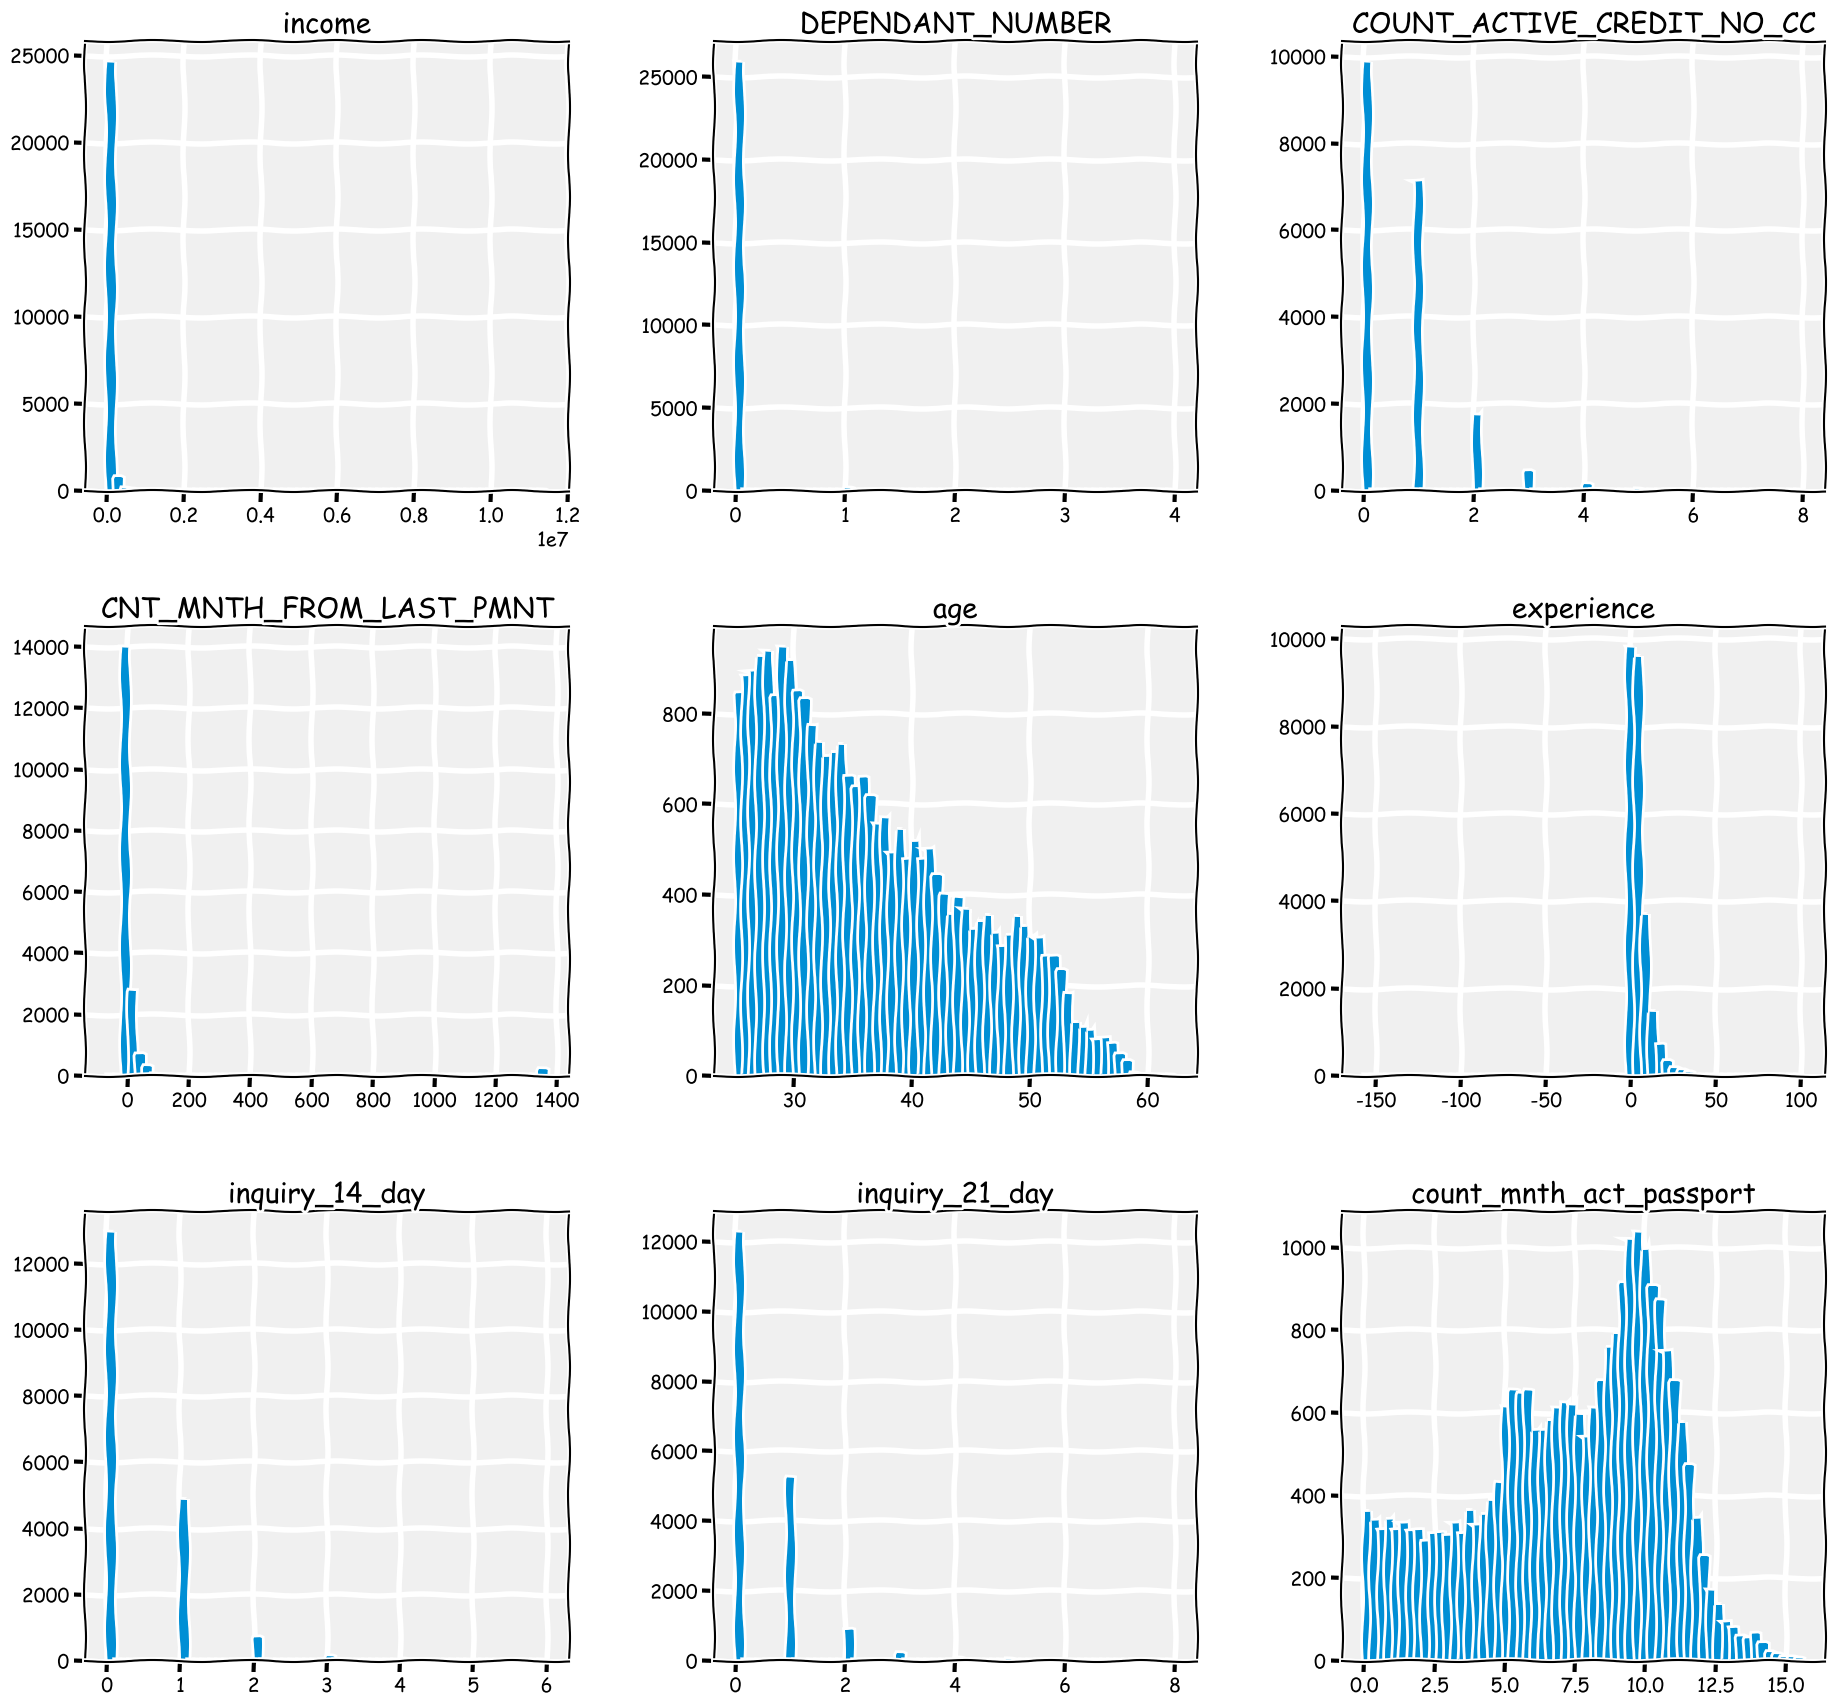

In [2191]:
accept_train[numerical].hist(figsize = (20, 20), bins=60);

из графиков и статистик выше делаем следующие выводы: 
- больше всего кредиты у просят люди с небольшим заработком, да и вообще у заработка в выборке довольно длинный, но легкий хвост справа, медиана приближина все-таки в нижней границе заработка
- практически ни у кого нет иждивенцев
- у большей части клиентов нет активных кредитов на момент запроса, но все-таки довольно много у кого есть хотя бы один
- при этом у большинства последний платеж был около месяца назад, но есть клиенты с очень большой просрочкой вплоть до 1400 месяцев, это больше 10 лет, кажется, это выбросы и таких клиентов надо отсеять, ведь у нас же клиенты от 25 до 70 лет, последний кредит мог бы быть максимально 45 лет назад, а это 540 месяцев, сделаю это верхней границей далее
- с увеличением возраста уменьшается количество случаев запроса кредита, то есть большинство клиентов около 35 лет
- у большинства нет опыта и запросов в кредитное бюро
- у большиснтва последний паспрт был получен около 10 лет назад, что логично и должно коррелировать с возрастом, все его меняли как минимум в 20 лет, а кто-то еще терял

посмотрим еще на корреляционную матрицу

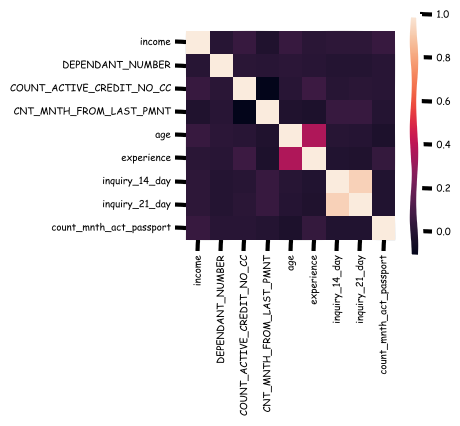

In [2192]:
correlations = accept_train.select_dtypes(include=['float64']).corr()
plt.figure(figsize=(3, 3))
plt.rcParams['font.size'] = '7'
sns.heatmap(correlations, square=True);

на рисунке очень заметна положительная сильная корреляция количества запросов за последние 14 и 21 день, что супер логично, ведь второе включает в себя первое. а так же заметим сильную корреляцию возраста и опыта, что тоже максимально логично, ведь сложно быть молодым и иметь много опыта :) отрицательная корреляция наблюдается у количества активных кредитов и времени с последнего платежа, потому что с увеличением кредитов вероятность того, что тебе недавно надо было за него заплатить увеличивается, так что переменная CNT_MNTH_FROM_LAST_PMNT скорее уменьшается, но там несильная отрицательная корреляция

заметим еще странности в данных: почему-то в доходе есть нулевые значения, хотя по политике банка не выдают кредиты людям, у которых зп меньше 20к, потому что их должны были отсеять сразу на первом этапе скрининга

In [2193]:
accept_train[accept_train['income'] < 20000].shape[0] / accept_train.shape[0]

0.11100871635372268

таких людей около 11%, в принципе мы можем себе позволить их удалить

In [2194]:
def delete_small_salaries(data):
    data = data[data['income'] >= 20000]
    return data

accept_train, accept_test = apply([accept_train, accept_test], delete_small_salaries)

stats(accept_train[numerical])

,data type,unique values,unique %,null value,null %,nan value,nan %,min,max,mean,standart deviation,median
income,float64,13000,57.445868,0,0.000000,0,0.000000,20000.000000,1.145038e+07,67166.969775,119573.903668,45454.500000
DEPENDANT_NUMBER,float64,6,0.026513,22530,99.558109,1,0.004419,0.000000,4.000000e+00,0.005568,0.092425,0.000000
COUNT_ACTIVE_CREDIT_NO_CC,float64,10,0.044189,8545,37.759611,5636,24.904993,0.000000,8.000000e+00,0.665411,0.826342,0.000000
CNT_MNTH_FROM_LAST_PMNT,float64,12841,56.743261,8,0.035351,6784,29.977905,-66.559028,1.364857e+03,19.902325,140.034973,0.923824
age,float64,17878,79.001326,0,0.000000,0,0.000000,25.000187,6.232055e+01,36.408924,8.127375,34.768493
experience,float64,15754,69.615555,0,0.000000,6,0.026513,-157.184939,1.011924e+02,4.921627,5.290341,3.366584
inquiry_14_day,float64,8,0.035351,11356,50.181175,6167,27.251436,0.000000,6.000000e+00,0.369617,0.619897,0.000000
inquiry_21_day,float64,10,0.044189,10750,47.503314,6167,27.251436,0.000000,8.000000e+00,0.432485,0.693300,0.000000
count_mnth_act_passport,float64,15725,69.487406,3,0.013257,0,0.000000,-0.019126,1.561644e+01,7.318934,3.341666,7.887978


теперь заметим, что в количестве месяцев, прошедших с момента последнего платежа по предыдущему кредиту, есть отрицательные значения, тоже самое в количестве опыта и в времени с момента выдачи паспорта. при этом в опыте есть слишком большие значения, хотя если кредит не выдают людям младше 25 и старше 70, то максимальный размер опыта может быть 45 лет, установим это как верхнюю границу

In [2195]:
indexes = (accept_train['CNT_MNTH_FROM_LAST_PMNT'] > 0)  & (accept_train['CNT_MNTH_FROM_LAST_PMNT'] < 540)  & (accept_train['experience'] > 0) & (accept_train['experience'] < 45) & (accept_train['count_mnth_act_passport'] > 0)
print(1 - accept_train[indexes].shape[0] / accept_train.shape[0])

0.3243923994697304


то есть если будем удалять все некорректные значения, то удалим еще > 32 процентов выборки, кажется, лучше так не делать, а заменить просто их на NaN и дальше заполнить просто как пропуски + аналогично сделаю с теми, у кого слишком большая просрочка, просто заменю на наны

In [2196]:
def fill_with_nans(data):
    indexes = (data['CNT_MNTH_FROM_LAST_PMNT'] < 0)
    data.loc[indexes, 'CNT_MNTH_FROM_LAST_PMNT'] = np.nan
    
    indexes = (data['CNT_MNTH_FROM_LAST_PMNT'] > 540)
    data.loc[indexes, 'CNT_MNTH_FROM_LAST_PMNT'] = np.nan

    indexes = (data['experience'] < 0)
    data.loc[indexes, 'experience'] = np.nan
    
    indexes = (data['experience'] > 45)
    data.loc[indexes, 'experience'] = np.nan

    indexes = (data['count_mnth_act_passport'] < 0)
    data.loc[indexes, 'count_mnth_act_passport'] = np.nan

    return data

accept_train, accept_test = apply([accept_train, accept_test], fill_with_nans)
stats(accept_train[['CNT_MNTH_FROM_LAST_PMNT', 'experience', 'count_mnth_act_passport']])

,data type,unique values,unique %,null value,null %,nan value,nan %,min,max,mean,standart deviation,median
CNT_MNTH_FROM_LAST_PMNT,float64,12304,54.370305,8,0.035351,7328,32.381794,0.000000,86.510842,5.479911,11.748946,0.927923
experience,float64,15752,69.606717,0,0.000000,8,0.035351,0.065753,40.804791,4.924537,5.139920,3.366584
count_mnth_act_passport,float64,15724,69.482987,3,0.013257,2,0.008838,0.000000,15.616438,7.319582,3.341103,7.887978


ну и заполним теперь все пропуски средним или медианой (медианой для тех случаев, когда у нас мало уникальных значений и они все целые), потому что это самый легкий вариант......

In [2197]:
median = ['DEPENDANT_NUMBER', 'COUNT_ACTIVE_CREDIT_NO_CC', 'inquiry_14_day', 'inquiry_21_day']
mean = [feature for feature in numerical if feature not in median]

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
accept_train[mean] = imputer.fit_transform(accept_train[mean])
accept_test[mean] = imputer.transform(accept_test[mean])

imputer = SimpleImputer(missing_values=np.nan, strategy='median')
accept_train[median] = imputer.fit_transform(accept_train[median])
accept_test[median] = imputer.transform(accept_test[median])

stats(accept_train[numerical])

,data type,unique values,unique %,null value,null %,nan value,nan %,min,max,mean,standart deviation,median
income,float64,13000,57.445868,0,0.000000,0,0.0,20000.000000,1.145038e+07,67166.969775,119573.903668,45454.500000
DEPENDANT_NUMBER,float64,5,0.022095,22531,99.562528,0,0.0,0.000000,4.000000e+00,0.005568,0.092423,0.000000
COUNT_ACTIVE_CREDIT_NO_CC,float64,9,0.039770,14181,62.664605,0,0.0,0.000000,8.000000e+00,0.499691,0.771742,0.000000
CNT_MNTH_FROM_LAST_PMNT,float64,12304,54.370305,8,0.035351,0,0.0,0.000000,8.651084e+01,5.479911,9.661090,2.947457
age,float64,17878,79.001326,0,0.000000,0,0.0,25.000187,6.232055e+01,36.408924,8.127375,34.768493
experience,float64,15752,69.606717,0,0.000000,0,0.0,0.065753,4.080479e+01,4.924537,5.139012,3.367988
inquiry_14_day,float64,7,0.030932,17523,77.432612,0,0.0,0.000000,6.000000e+00,0.268891,0.553745,0.000000
inquiry_21_day,float64,9,0.039770,16917,74.754750,0,0.0,0.000000,8.000000e+00,0.314627,0.621896,0.000000
count_mnth_act_passport,float64,15724,69.482987,3,0.013257,0,0.0,0.000000,1.561644e+01,7.319582,3.340955,7.887978


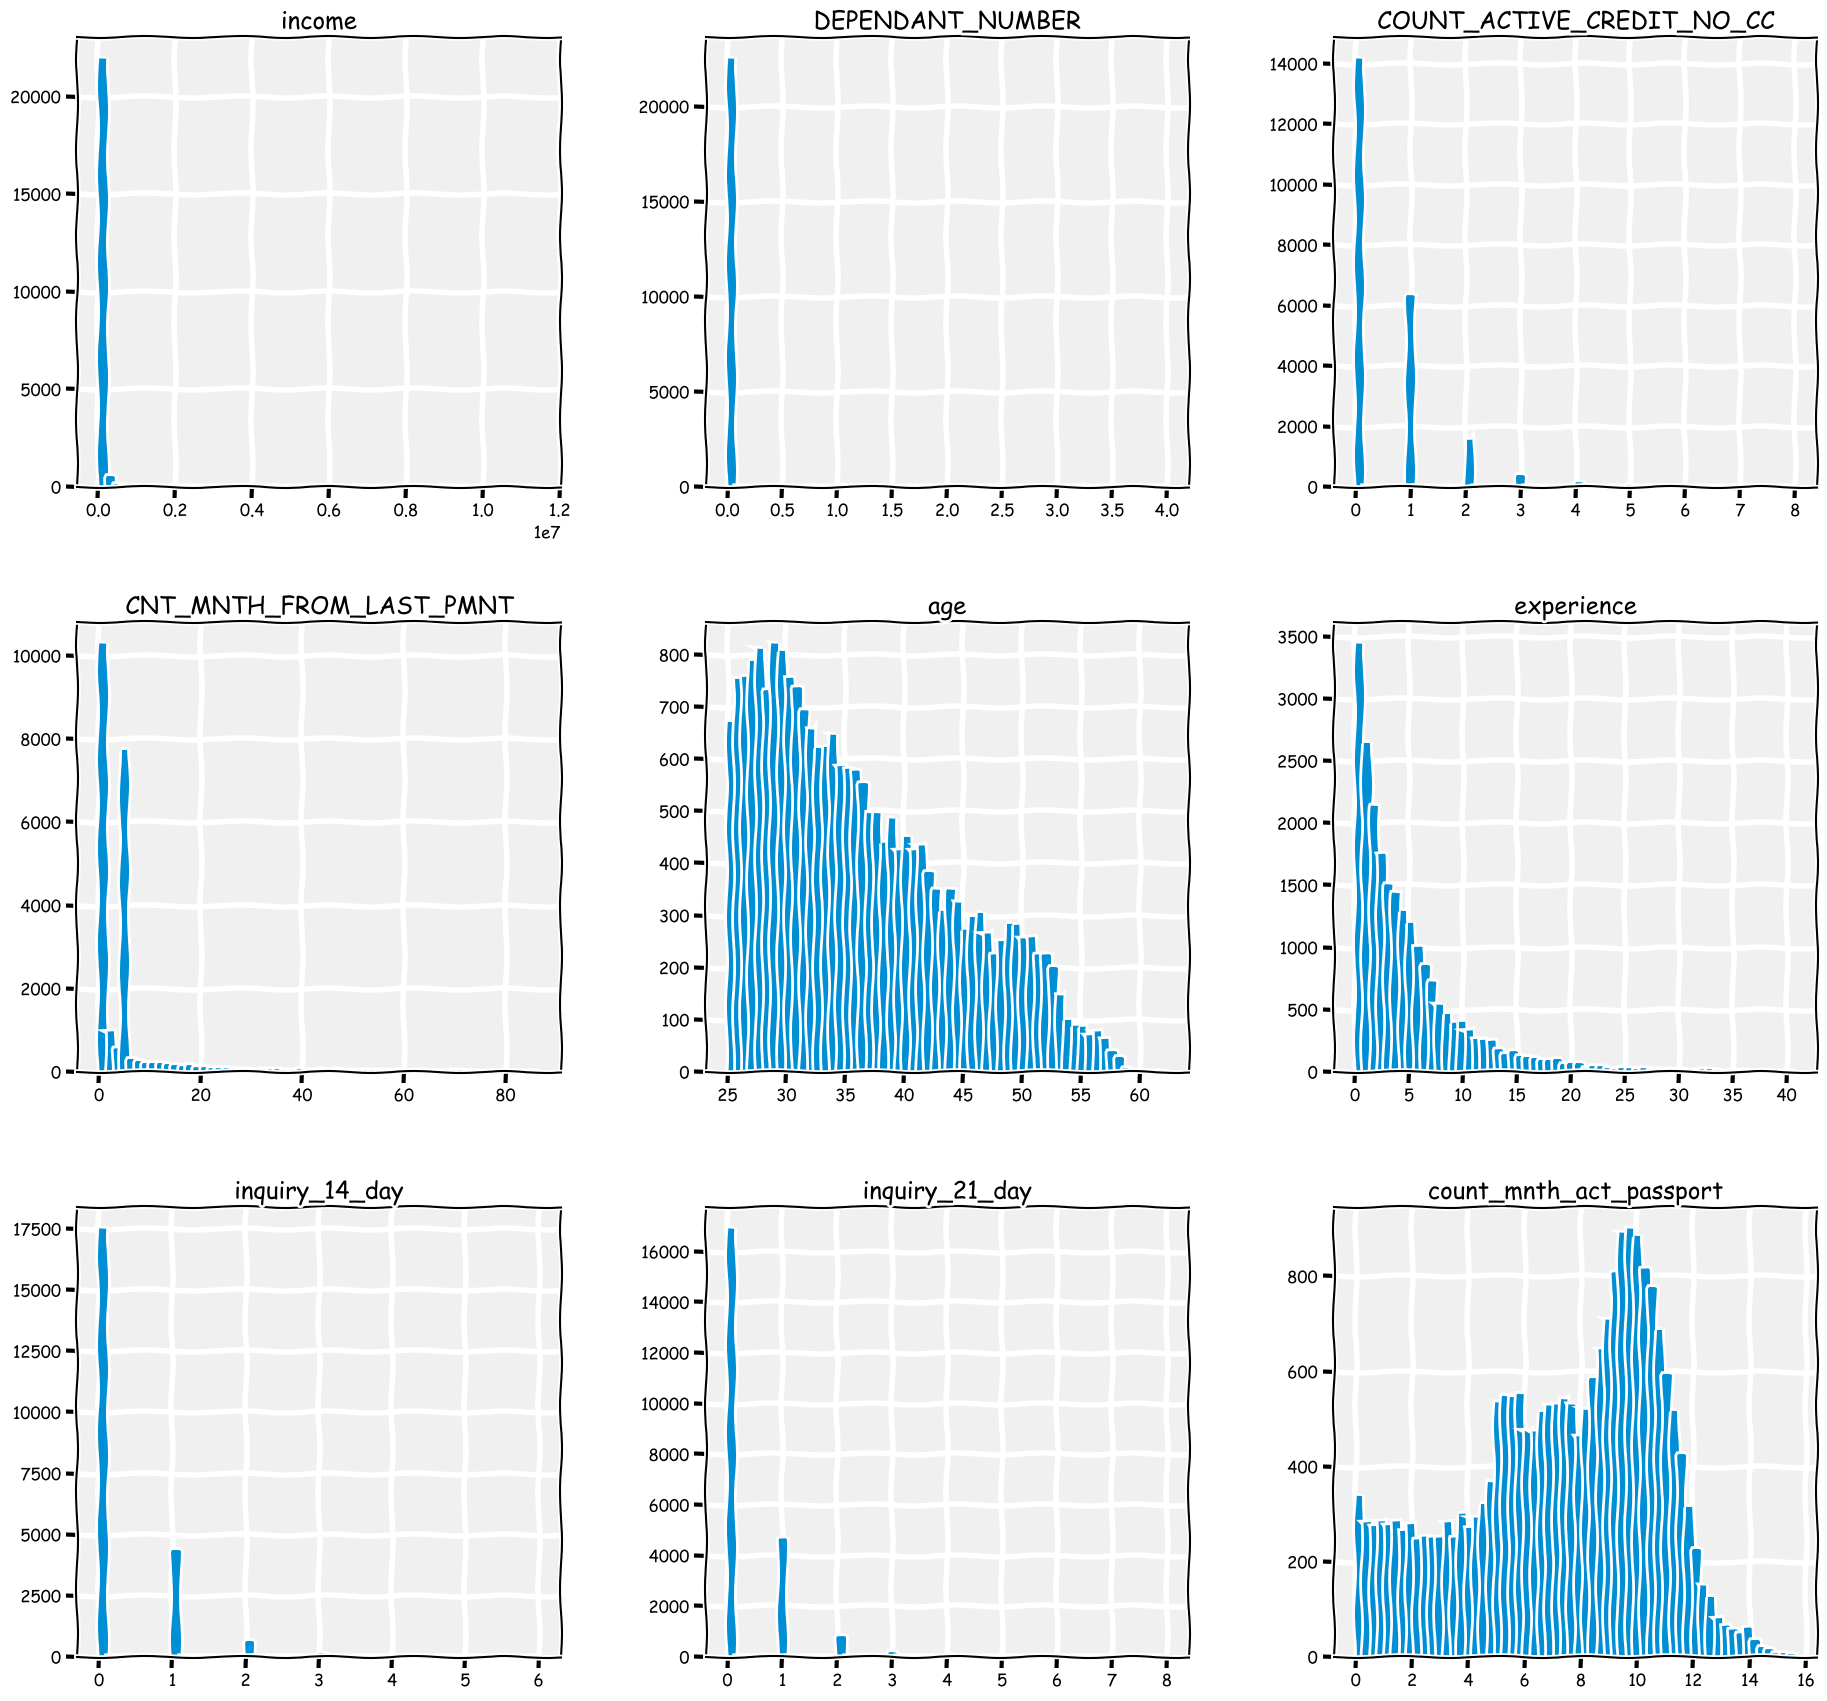

In [2198]:
plt.rcParams['font.size'] = '12'
accept_train[numerical].hist(figsize = (20, 20), bins=60);

распределения после замены средним поменялись незначительно, что отлично! :)

# Создание дополнительных переменных. Максимально - 1 балл

Будьте креативными, чем больше переменных, тем больше балл! При этом переменные должны быть логичными, нелогичные переменные не принимаются

- 0 баллов, если задание не выполнено
- 0.5 баллов - создана 2 дополнительные переменные 
- 1 балл создано больше 3 переменных 


In [2199]:
def create_features(data):
    # отношение опыта к возрасту
    data['ratio_experience'] = data['experience'] / data['age']
    
    # флаг, есть ли кредит
    data['has_credits'] = 0.0
    indexes = (data['COUNT_ACTIVE_CREDIT_NO_CC'] != 0)
    data.loc[indexes, 'has_credits'] = 1.0
    
    # флаг, есть ли на данный момент просрочка больше месяца
    data['has_delay'] = 0.0
    indexes = (data['has_credits'] == 1.0) & (data['CNT_MNTH_FROM_LAST_PMNT'] >= 1.0)
    data.loc[indexes, 'has_delay'] = 1.0
    
    # заработная плата на каждого иждивенца
    data['income_to_dependants'] = data['income'] / (data['DEPENDANT_NUMBER'] + 1)
    return data

accept_train, accept_test = apply([accept_train, accept_test], create_features)

,data type,unique values,unique %,null value,null %,nan value,nan %,min,max,mean,standart deviation,median
ratio_experience,float64,21644,95.642952,0,0.000000,0,0.0,0.001370,7.318795e-01,0.130207,0.118081,0.096185
has_credits,float64,2,0.008838,14181,62.664605,0,0.0,0.000000,1.000000e+00,0.373354,0.483706,0.000000
has_delay,float64,2,0.008838,20478,90.490499,0,0.0,0.000000,1.000000e+00,0.095095,0.293353,0.000000
income_to_dependants,float64,13021,57.538665,0,0.000000,0,0.0,6666.666667,1.145038e+07,67002.355910,119541.157165,45327.000000


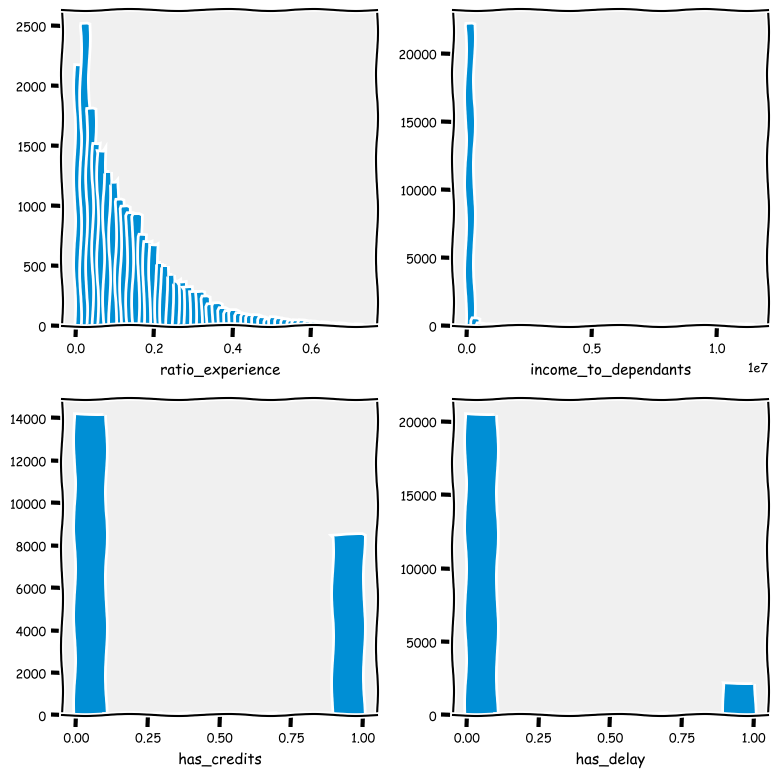

In [2200]:
new_features = ['ratio_experience', 'has_credits', 'has_delay', 'income_to_dependants']
stats(accept_train[new_features])

plt.figure(figsize=(8, 8))

plt.rcParams['font.size'] = '9'
plt.subplot(2, 2, 1)
plt.xkcd()
plt.hist(accept_train['ratio_experience'].values, bins=50)
plt.xlabel('ratio_experience')

plt.rcParams['font.size'] = '9'
plt.subplot(2, 2, 2)
plt.xkcd()
plt.hist(accept_train['income_to_dependants'].values, bins=50)
plt.xlabel('income_to_dependants')

plt.rcParams['font.size'] = '9'
plt.subplot(2, 2, 3)
plt.xkcd()
plt.hist(accept_train['has_credits'].values)
plt.xlabel('has_credits')

plt.rcParams['font.size'] = '9'
plt.subplot(2, 2, 4)
plt.xkcd()
plt.hist(accept_train['has_delay'].values)
plt.xlabel('has_delay')

plt.tight_layout();

# Построение модели на одобренных заявках. Максимально - 4 балла
Необхоимо построить логистическую регрессию на WoE переменных. 

Если построена любая другая модель, балл = 0

Необходимо расчитать WoE преобразование - максимально - 3 балла



Расчет WoE должен быть в 2 этапа:

1 шаг. Fine Classing (1 балл). Разбиение на большое количество бинов(интервалов)
  - обычно интервальные переменные делят по  20, 30 и так далее интервалов
  - для категориальных переменных - одна категория - одна группа
  - далее для каждой группы рассчитываем WoE

2 шаг. Coarse classing (2 балла). Укрупнение интервалов, которые получены на 1-ом шаге. В итоге должно получится не больше 5-10 интервалов. 
  - Обычно объединяют группы с похожими значениями WoE 
  - WoE должен быть монотонным, то есть после вашего объединения результат должен быть интерпретируемым (необходимо продемонстрировать графически, что WoE монотонен )



построение и оценка логистической регресии - максимально 1 балл
- построена только логистическая регрессия - 0.3 балла
- сделана оценка модели - 0.3 балла
- построена скоркарта - 0.4 балла

Напомню, что для скоркарты нужны следующие формулы (детали в лекции и семинаре)

$ \text{Score}_i =  (\beta_i × \text{WoE}_i + \alpha/n) \times \text{Factor} + \text{Offset}$ , где

- $\text{Factor} = \text{pdo}/\ln(2)$

- $\text{Offset} = \text{Target Score} - (\text{Factor} \times \ln(\text{Target Odds}))$


In [2201]:
bins_train, bins_test  = copy(accept_train), copy(accept_test)


# to_encode = ['INCOME_TYPE', 'EDUCATION_', 'CUSTOMER_CATEGORY_']

interval_features = ['income', 'age', 'experience', 'count_mnth_act_passport', 
                     'ratio_experience', 'income_to_dependants']

smaller_bins_features = ['CNT_MNTH_FROM_LAST_PMNT']


# trasformer = OrdinalEncoder()
# woe_accept_train[to_encode] = trasformer.fit_transform(woe_accept_train[to_encode])
# woe_accept_test[to_encode] = trasformer.transform(woe_accept_test[to_encode])


bins = dict()
lists = [interval_features, smaller_bins_features]
n_bins = [30, 4]

for k in range(len(lists)):
    for feature in lists[k]:        
        bins_train[feature + '_interval'] = pd.qcut(bins_train[feature], n_bins[k])
        bins_train[feature + '_bin'] = pd.qcut(bins_train[feature], n_bins[k], labels=[*range(n_bins[k])])

        intervals = bins_train[feature + '_interval'].unique()
        labels = bins_train[feature + '_bin'].unique()
        
        bins[feature] = dict()
        for i in range(len(intervals)):
            bins[feature][labels[i]] = intervals[i]

        def select_bin(value):
            for label in bins[feature]:
                if value in bins[feature][label]:
                    return label

        bins_test[feature + '_bin'] = bins_test[feature].map(select_bin)

In [2202]:
bins_train.sample(5)

,target,INCOME_TYPE,EDUCATION_,CUSTOMER_CATEGORY_,income,DEPENDANT_NUMBER,IS_EMPL,COUNT_ACTIVE_CREDIT_NO_CC,CNT_MNTH_FROM_LAST_PMNT,age,experience,inquiry_14_day,inquiry_21_day,count_mnth_act_passport,UID,ratio_experience,has_credits,has_delay,income_to_dependants,income_interval,income_bin,age_interval,age_bin,experience_interval,experience_bin,count_mnth_act_passport_interval,count_mnth_act_passport_bin,ratio_experience_interval,ratio_experience_bin,income_to_dependants_interval,income_to_dependants_bin,CNT_MNTH_FROM_LAST_PMNT_interval,CNT_MNTH_FROM_LAST_PMNT_bin
11691,0,OTHER,advanced,Regular,55000.0,0.0,0,2.0,0.538866,41.455064,8.404372,1.0,1.0,5.071502,52025,0.202734,1.0,0.0,55000.0,"(54072.8, 58076.5]",18,"(41.436, 42.643]",22,"(7.644, 8.601]",24,"(4.886, 5.252]",7,"(0.194, 0.212]",23,"(53940.0, 58000.0]",18,"(-0.001, 0.724]",0
26691,0,OTHER,elementary,Regular,20000.0,0.0,0,0.0,5.479911,41.468493,6.997260,0.0,0.0,10.271233,117783,0.168737,0.0,0.0,20000.0,"(19999.999, 21252.3]",0,"(41.436, 42.643]",22,"(6.887, 7.644]",23,"(10.074, 10.311]",23,"(0.163, 0.178]",21,"(6666.666, 21127.3]",0,"(2.947, 5.48]",2
29893,0,OTHER,elementary,Corporate,32091.0,0.0,1,0.0,1.410282,25.358904,5.038468,0.0,0.0,5.252055,132049,0.198686,0.0,0.0,32091.0,"(31734.8, 33764.7]",8,"(24.999, 25.693]",0,"(4.876, 5.304]",19,"(4.886, 5.252]",7,"(0.194, 0.212]",23,"(31593.6, 33651.5]",8,"(0.724, 2.947]",1
10397,0,OTHER,beginner,Corporate,90045.0,0.0,1,0.0,5.479911,30.871046,0.479265,0.0,0.0,9.451868,46416,0.015525,0.0,0.0,90045.0,"(85000.0, 95091.5]",24,"(30.506, 31.137]",9,"(0.35, 0.48]",1,"(9.424, 9.636]",20,"(0.0134, 0.0164]",2,"(85000.0, 95000.0]",24,"(2.947, 5.48]",2
17389,0,OTHER,advanced,Corporate,43842.0,0.0,1,1.0,10.082930,56.079235,34.877962,0.0,0.0,10.302620,77070,0.621941,1.0,1.0,43842.0,"(43614.8, 45454.5]",14,"(52.847, 62.321]",29,"(17.772, 40.805]",29,"(10.074, 10.311]",23,"(0.416, 0.732]",29,"(43500.0, 45327.0]",14,"(5.48, 86.511]",3


In [2203]:
bins_test.sample(5)

,target,INCOME_TYPE,EDUCATION_,CUSTOMER_CATEGORY_,income,DEPENDANT_NUMBER,IS_EMPL,COUNT_ACTIVE_CREDIT_NO_CC,CNT_MNTH_FROM_LAST_PMNT,age,experience,inquiry_14_day,inquiry_21_day,count_mnth_act_passport,UID,ratio_experience,has_credits,has_delay,income_to_dependants,income_bin,age_bin,experience_bin,count_mnth_act_passport_bin,ratio_experience_bin,income_to_dependants_bin,CNT_MNTH_FROM_LAST_PMNT_bin
27454,0,OTHER,high,Corporate,40602.0,0.0,1,4.0,0.669041,34.312748,9.929186,0.0,0.0,9.677132,121413,0.289373,1.0,0.0,40602.0,12,14,26,21,26,12,0
30283,0,OTHER,elementary,Corporate,22995.0,0.0,1,0.0,0.958132,25.423205,1.209507,0.0,0.0,5.351972,133874,0.047575,0.0,0.0,22995.0,2,0,7,8,8,2,1
3416,0,OTHER,elementary,Corporate,64565.0,0.0,1,0.0,5.479911,26.294693,0.894693,0.0,0.0,4.568665,15295,0.034026,0.0,0.0,64565.0,20,1,5,6,6,20,2
21597,0,2NDFL,high,Regular,31102.0,0.0,0,1.0,0.140681,29.904110,0.746493,1.0,1.0,9.331507,95265,0.024963,1.0,0.0,31102.0,7,8,4,19,5,7,0
10501,0,OTHER,elementary,Regular,100000.0,0.0,0,1.0,0.695363,36.475410,0.636867,0.0,0.0,4.174863,46863,0.017460,1.0,0.0,100000.0,25,17,3,5,3,25,0


далее при подсчете WoE обнаружилась ошибка, что нет плохих объектов со значениями переменных inquiry_14_day и inquiry_21_day больше двух, так что WoE не считался. заменю у всех объектов значение больше 2 на ровно 2 и тогда смысл этих переменных будут уже иметь не прямое значение. они будут рассматриваться как категориальные признаки с Ordinal Encoding'ом: запросы 0, 1 и >= 2 раз

In [2204]:
inquiries = ['inquiry_14_day', 'inquiry_21_day']
for inquiry in inquiries:
    indexes = (bins_train[inquiry] > 2)
    bins_train.loc[indexes, inquiry] = 2.0
    
    indexes = (bins_test[inquiry] > 2)
    bins_test.loc[indexes, inquiry] = 2.0

    print(bins_train[inquiry].unique())

[0. 1. 2.]
[0. 1. 2.]


In [2205]:
# возьму функцию подсчета WoE и IV из ноутбука с семинара
def calculate_woe_iv(dataset, feature, target):
    lst = []
    for i in range(dataset[feature].nunique()):
        val = list(dataset[feature].unique())[i]
        lst.append({
            'Value': val,
            'All': dataset[dataset[feature] == val].count()[feature],
            'Good': dataset[(dataset[feature] == val) & (dataset[target] == 0)].count()[feature],
            'Bad': dataset[(dataset[feature] == val) & (dataset[target] == 1)].count()[feature]
        })
        
    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()
    dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad'])
    dset = dset.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WoE']
    iv = dset['IV'].sum()
    
    dset = dset.sort_values(by='WoE')
    
    return dset, iv

In [2206]:
scorecard = pd.DataFrame()

train, test = copy(bins_train), copy(bins_test)

features = train.columns
features = features.drop(['UID', 'target'])

interval_features = ['income', 'age', 'experience', 'count_mnth_act_passport', 
                     'ratio_experience', 'income_to_dependants', 'CNT_MNTH_FROM_LAST_PMNT']

categorical = ['INCOME_TYPE', 'EDUCATION_', 'CUSTOMER_CATEGORY_', 'DEPENDANT_NUMBER', 
               'IS_EMPL', 'COUNT_ACTIVE_CREDIT_NO_CC', 'inquiry_14_day', 
               'inquiry_21_day', 'has_credits', 'has_delay']

for feature in interval_features:
    df, iv = calculate_woe_iv(train, feature + '_bin', 'target')
    df['feature'] = feature
    train = train.merge(df[['Value', 'WoE']], how='inner', left_on=feature + '_bin', right_on='Value')
    train = train.rename(columns={'WoE' : 'WoE' + '_' + feature})
    
    train = train.drop(columns = [feature, feature + '_bin', feature + '_interval', 'Value'])
    
#     test = test.merge(df[['Value', 'WoE']], how='inner', left_on=feature + '_bin', right_on='Value')
#     test = test.rename(columns={'WoE' : 'WoE' + '_' + feature})

    
#     test = test.drop(columns = [feature, feature + '_bin', 'Value'])
    scorecard = pd.concat([scorecard, df[['feature', 'Value', 'WoE']]])    
    print(feature, 'IV =', iv)

for feature in categorical:
    df, iv = calculate_woe_iv(train, feature , 'target')
    df['feature'] = feature
    train = train.merge(df[['Value', 'WoE']], how='inner', left_on=feature, right_on='Value' )
    train = train.rename(columns={'WoE':'WoE'+'_'+feature})
    train = train.drop(columns = [feature, 'Value'])
    
#     test = test.merge(df[['Value', 'WoE']], how='inner', left_on=feature, right_on='Value' )
#     test = test.rename(columns={'WoE':'WoE'+'_'+feature})
#     test = test.drop(columns = [feature, 'Value'])
    scorecard = pd.concat([scorecard, df[['feature', 'Value', 'WoE']]])
   
    print(feature, 'IV =',iv)

income IV = 0.24050460126204024
age IV = 0.06309477206348758
experience IV = 0.1768251074796839
count_mnth_act_passport IV = 0.10575705987852235
ratio_experience IV = 0.14115745752768932
income_to_dependants IV = 0.24799582600484918
CNT_MNTH_FROM_LAST_PMNT IV = 0.08069885090396023
INCOME_TYPE IV = 0.011468632074509863
EDUCATION_ IV = 0.018913102439355796
CUSTOMER_CATEGORY_ IV = 0.5828030604371008
DEPENDANT_NUMBER IV = 0.002868153297607072
IS_EMPL IV = 0.8161363545197023
COUNT_ACTIVE_CREDIT_NO_CC IV = 0.05153147487403052
inquiry_14_day IV = 0.11455799336469788
inquiry_21_day IV = 0.09962710344400125
has_credits IV = 0.0008616266877657756
has_delay IV = 0.00010218110836804464


In [2207]:
for feature in interval_features:
    current = scorecard[scorecard['feature'] == feature]
    scorecard.loc[scorecard['feature'] == feature, 'interval'] = scorecard.loc[scorecard['feature'] == feature, 'Value'].map(lambda value: bins[feature][value])

scorecard.sample(5)

,feature,Value,WoE,interval
9,income,1,0.397885,"(21252.3, 22912.2]"
29,income_to_dependants,26,0.310873,"(105009.6, 123038.4]"
2,DEPENDANT_NUMBER,2.0,-0.924544,NaN
24,ratio_experience,4,-0.355997,"(0.0196, 0.0242]"
15,income,8,0.601244,"(31734.8, 33764.7]"


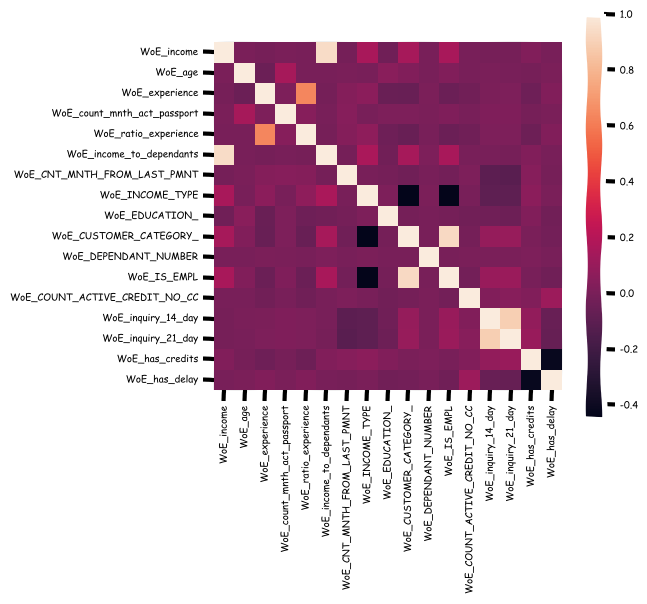

In [2208]:
correlations_woe = train.select_dtypes(include=['float64']).corr()
plt.figure(figsize=(5, 5))
plt.rcParams['font.size'] = '7'
sns.heatmap(correlations_woe, square=True)
plt.show()

судя по данным и матрице корреляций:
- у нас довольно сильная корреляция между inquiry_14_days и inquiry_21_days, причем у первого чуть больше IV, поэтому второй признак удаляем
- так же есть корреляция между income и income_to_dependants, потому что второй признак сделан из первого, но у второго, опять же чуть больше IV, удаляем первый
- аналогично у ratio_experience и experience, удаляем первый

еще удалим признаки, у которых IV < 0.015, это INCOME_TYPE, DEPENDANT_NUMBER, has_credits, has_delay

In [2209]:
using_features = list(scorecard['feature'].unique())

using_features.remove('inquiry_21_day')
using_features.remove('income')
using_features.remove('ratio_experience')

using_features.remove('INCOME_TYPE')
using_features.remove('DEPENDANT_NUMBER')
using_features.remove('has_credits')
using_features.remove('has_delay')

using_features

['age',
 'experience',
 'count_mnth_act_passport',
 'income_to_dependants',
 'CNT_MNTH_FROM_LAST_PMNT',
 'EDUCATION_',
 'CUSTOMER_CATEGORY_',
 'IS_EMPL',
 'COUNT_ACTIVE_CREDIT_NO_CC',
 'inquiry_14_day']

для удобства сразу удалим из скоркарты признаки, которые не используем

In [2210]:
scorecard_features = scorecard['feature'].unique()
for feature in scorecard_features:
    if feature not in using_features:
        scorecard = scorecard[scorecard['feature'] != feature]

scorecard['feature'].unique()

array(['age', 'experience', 'count_mnth_act_passport',
       'income_to_dependants', 'CNT_MNTH_FROM_LAST_PMNT', 'EDUCATION_',
       'CUSTOMER_CATEGORY_', 'IS_EMPL', 'COUNT_ACTIVE_CREDIT_NO_CC',
       'inquiry_14_day'], dtype=object)

теперь хотим объединить бины, сделать их побольше. выберу только те, у которых изначально бинов больше 10 (они лежат в интервальных фичах), чтобы сделать 5-7

In [2211]:
new_bins = dict()
n_bins = 7

to_coarse_classing = [feature for feature in interval_features if feature in using_features]

for feature in to_coarse_classing:
    current = (scorecard['feature'] == feature)
    scorecard.loc[current, 'new_interval'] = list(pd.qcut(scorecard.loc[current, 'WoE'], n_bins))
    scorecard.loc[current, 'new_bin'] = list(pd.qcut(scorecard.loc[current, 'WoE'], n_bins, labels=[*range(n_bins)]))
    
    prev_bins = scorecard.loc[current, 'Value']
    new_bins = scorecard.loc[current, 'new_bin']
    for i in range(prev_bins.shape[0]):
        bins_train.loc[bins_train[feature + '_bin'] == prev_bins.iloc[i], feature + '_new_bin'] = new_bins.iloc[i]        
        bins_test.loc[bins_test[feature + '_bin'] == prev_bins.iloc[i], feature + '_new_bin'] = new_bins.iloc[i]

In [2212]:
bins_test

,target,INCOME_TYPE,EDUCATION_,CUSTOMER_CATEGORY_,income,DEPENDANT_NUMBER,IS_EMPL,COUNT_ACTIVE_CREDIT_NO_CC,CNT_MNTH_FROM_LAST_PMNT,age,experience,inquiry_14_day,inquiry_21_day,count_mnth_act_passport,UID,ratio_experience,has_credits,has_delay,income_to_dependants,income_bin,age_bin,experience_bin,count_mnth_act_passport_bin,ratio_experience_bin,income_to_dependants_bin,CNT_MNTH_FROM_LAST_PMNT_bin,age_new_bin,experience_new_bin,count_mnth_act_passport_new_bin,income_to_dependants_new_bin,CNT_MNTH_FROM_LAST_PMNT_new_bin
23507,0,2NDFL,advanced,Regular,27197.0,0.0,0,0.0,5.479911,32.199865,1.775342,0.0,0.0,9.186301,103743,0.055135,0.0,0.0,27197.0,5,11,9,18,9,5,2,6.0,3.0,2.0,6.0,0.0
10202,0,OTHER,high,Regular,70000.0,0.0,0,0.0,27.510237,31.386301,0.158904,1.0,1.0,10.553425,45609,0.005063,0.0,0.0,70000.0,21,10,0,24,0,21,3,2.0,4.0,4.0,1.0,6.0
6395,0,OTHER,elementary,Corporate,80000.0,0.0,1,2.0,0.274373,34.101370,0.497964,2.0,2.0,3.372603,28657,0.014602,1.0,0.0,80000.0,23,14,2,4,2,23,0,5.0,5.0,1.0,1.0,2.0
5665,0,2NDFL,advanced,Regular,32653.0,0.0,0,0.0,5.479911,45.268867,3.731507,0.0,0.0,0.175342,25340,0.082430,0.0,0.0,32653.0,8,24,15,0,13,8,2,6.0,1.0,0.0,6.0,0.0
21302,0,OTHER,elementary,Regular,35000.0,0.0,0,1.0,0.503114,29.022794,1.099506,1.0,1.0,8.054645,93897,0.037884,1.0,0.0,35000.0,9,6,6,15,7,9,0,5.0,2.0,6.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26016,0,2NDFL,elementary,Regular,91711.0,0.0,0,0.0,5.479911,36.629725,12.315068,0.0,0.0,11.690411,114792,0.336204,0.0,0.0,91711.0,24,17,27,28,28,24,2,0.0,6.0,3.0,2.0,0.0
1338,0,2NDFL,elementary,Regular,21733.0,0.0,0,0.0,5.479911,40.139726,8.956164,0.0,0.0,11.871233,6076,0.223125,0.0,0.0,21733.0,1,20,25,28,24,1,2,4.0,4.0,3.0,5.0,0.0
28007,0,OTHER,advanced,Regular,25000.0,0.0,0,0.0,5.479911,25.904110,0.345205,0.0,0.0,4.539726,123688,0.013326,0.0,0.0,25000.0,3,1,0,6,1,3,2,0.0,4.0,3.0,1.0,0.0
29017,0,2NDFL,elementary,Regular,45402.0,0.0,0,0.0,2.081676,41.897971,1.555506,0.0,0.0,8.377423,128124,0.037126,0.0,0.0,45402.0,14,22,8,16,7,15,1,4.0,0.0,5.0,5.0,4.0


In [2213]:
new_scorecard = pd.DataFrame()

train, test = copy(bins_train), copy(bins_test)

features = train.columns
features = features.drop(['UID', 'target'])

interval_features = ['age', 'experience', 'count_mnth_act_passport', 
                     'income_to_dependants', 'CNT_MNTH_FROM_LAST_PMNT']
 
categorical_features = ['EDUCATION_', 'CUSTOMER_CATEGORY_', 'IS_EMPL', 
                        'COUNT_ACTIVE_CREDIT_NO_CC', 'inquiry_14_day']

for feature in interval_features:
    df, iv = calculate_woe_iv(train, feature + '_new_bin', 'target')
    df['feature'] = feature
    train = train.merge(df[['Value', 'WoE']], how='inner', left_on=feature + '_new_bin', right_on='Value')
    train = train.rename(columns={'WoE' : 'WoE' + '_' + feature})
    
    train = train.drop(columns = [feature, feature + '_new_bin', feature + '_interval', 'Value'])
    
    test = test.merge(df[['Value', 'WoE']], how='inner', left_on=feature + '_new_bin', right_on='Value')
    test = test.rename(columns={'WoE' : 'WoE' + '_' + feature})
    
    test = test.drop(columns = ['Value'])
    new_scorecard = pd.concat([new_scorecard, df[['feature', 'Value', 'WoE']]])    
    print(feature, 'IV =', iv)

for feature in categorical_features:
    df, iv = calculate_woe_iv(train, feature , 'target')
    df['feature'] = feature
    train = train.merge(df[['Value', 'WoE']], how='inner', left_on=feature, right_on='Value' )
    train = train.rename(columns={'WoE':'WoE'+'_'+feature})
    train = train.drop(columns = [feature, 'Value'])
    
    test = test.merge(df[['Value', 'WoE']], how='inner', left_on=feature, right_on='Value' )
    test = test.rename(columns={'WoE':'WoE'+'_'+feature})
    test = test.drop(columns = ['Value'])
    new_scorecard = pd.concat([new_scorecard, df[['feature', 'Value', 'WoE']]])
   
    print(feature, 'IV =',iv)

age IV = 0.06157293713146075
experience IV = 0.15165899458160328
count_mnth_act_passport IV = 0.09914882102154204
income_to_dependants IV = 0.23473599278752313
CNT_MNTH_FROM_LAST_PMNT IV = 0.08069885090396023
EDUCATION_ IV = 0.018913102439355796
CUSTOMER_CATEGORY_ IV = 0.5828030604371008
IS_EMPL IV = 0.8161363545197023
COUNT_ACTIVE_CREDIT_NO_CC IV = 0.05153147487403052
inquiry_14_day IV = 0.11455799336469788


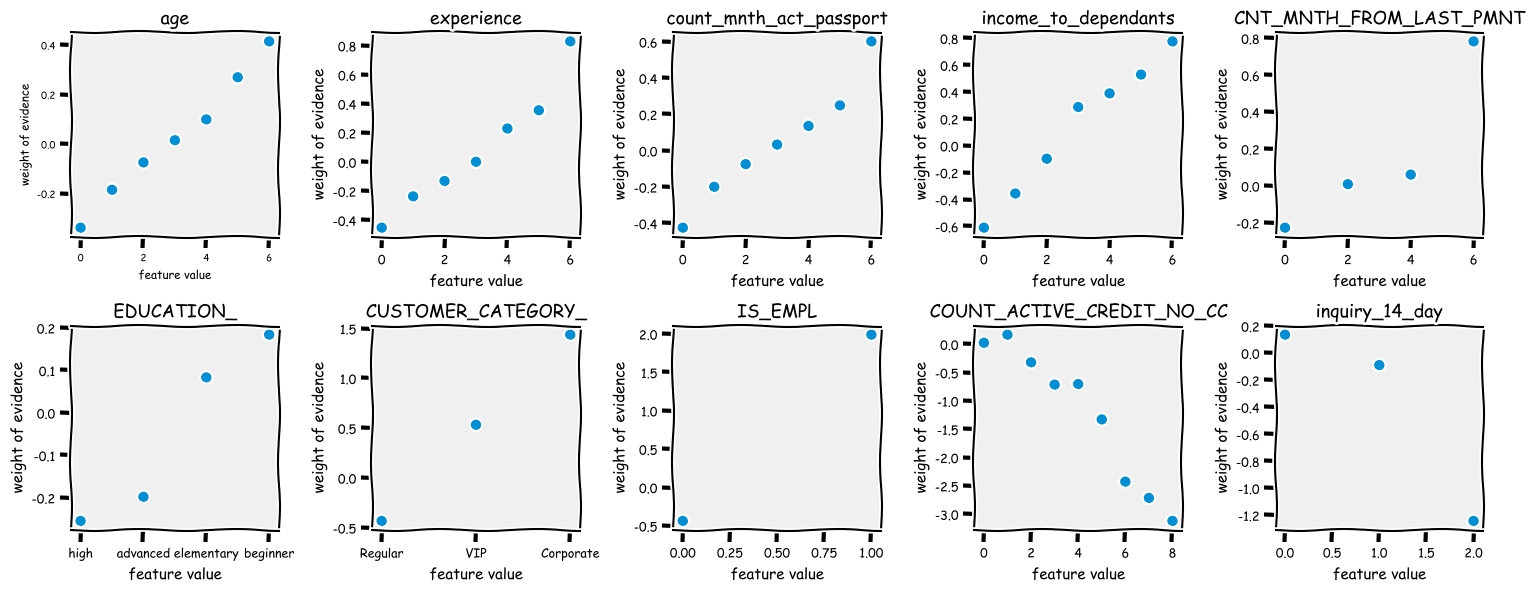

In [2214]:
features_to_plot = new_scorecard['feature'].unique()
length = int(len(features_to_plot) / 2 + (len(features_to_plot) % 2 != 0))

i = 1
plt.figure(figsize=(15, 6))

for feature in features_to_plot:
    plt.subplot(2, length, i)
    plt.rcParams['font.size'] = '9'
    data = new_scorecard[new_scorecard.feature == feature]
    plt.plot(data.Value, data.WoE, 'o')
    plt.xlabel('feature value')
    plt.ylabel('weight of evidence')
    plt.title(feature)
    i += 1

plt.tight_layout()

In [2215]:
def delete_columns(data):
    columns = list()
    for column in data.columns:
        if (column[:3] != 'WoE') & (column != 'target'):
            columns.append(column)
    return data.drop(columns=columns)

train, test = apply([train, test], delete_columns)

In [2216]:
features = train.columns
features

Index(['target', 'WoE_age', 'WoE_experience', 'WoE_count_mnth_act_passport',
       'WoE_income_to_dependants', 'WoE_CNT_MNTH_FROM_LAST_PMNT',
       'WoE_EDUCATION_', 'WoE_CUSTOMER_CATEGORY_', 'WoE_IS_EMPL',
       'WoE_COUNT_ACTIVE_CREDIT_NO_CC', 'WoE_inquiry_14_day'],
      dtype='object')

In [2217]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

features = train.columns.to_list()
target = 'target'
features.remove(target)

x_train = train[features]
x_test = test[features]
y_train = train[target]
y_test = test[target]

logreg = LogisticRegression()
logreg.fit(x_train, y_train)

LogisticRegression()

In [2218]:
features_coefs = pd.DataFrame(zip(x_train.columns, np.transpose(logreg.coef_.tolist()[0])),
                              columns=['features', 'coef'])

intercept = logreg.intercept_
print('intercept=', intercept)
features_coefs

intercept= [-3.81091269]


,features,coef
0,WoE_age,-0.751797
1,WoE_experience,-1.074418
2,WoE_count_mnth_act_passport,-0.804381
3,WoE_income_to_dependants,-0.863987
4,WoE_CNT_MNTH_FROM_LAST_PMNT,-1.147679
5,WoE_EDUCATION_,-1.314352
6,WoE_CUSTOMER_CATEGORY_,0.010092
7,WoE_IS_EMPL,-0.948855
8,WoE_COUNT_ACTIVE_CREDIT_NO_CC,-1.097005
9,WoE_inquiry_14_day,-0.919450


In [2219]:
y_pred = logreg.predict(x_test)
print('accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(x_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.98


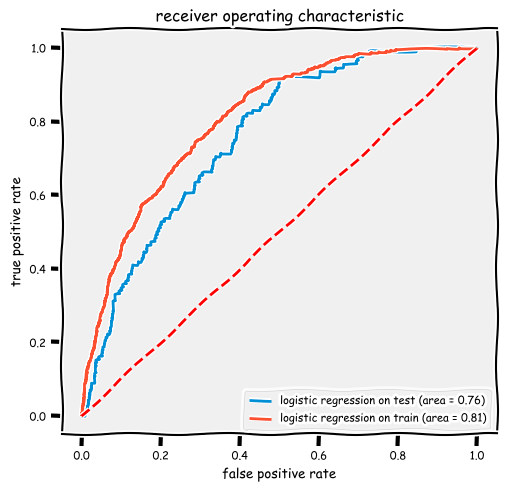

In [2227]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_test, logreg.predict_proba(x_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(x_test)[:,1])

logit_roc_auc_train = roc_auc_score(y_train, logreg.predict_proba(x_train)[:,1])
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, logreg.predict_proba(x_train)[:,1])

plt.figure(figsize=(5, 5))
plt.rc("font", size=8)

plt.plot(fpr, tpr, label='logistic regression on test (area = %0.2f)' % logit_roc_auc)
plt.plot(fpr_train, tpr_train, label='logistic regression on train (area = %0.2f)' % logit_roc_auc_train)
plt.plot([0, 1], [0, 1],'r--')

plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('receiver operating characteristic')
plt.legend(loc="lower right");

In [2229]:
fpr, tpr, thresholds = roc_curve(y_train, logreg.predict_proba(x_train)[:,1])
gmeans = np.sqrt(tpr + (1-fpr))

ix = np.argmax(gmeans)
print('best threshold = %f, g-mean = %.3f' % (thresholds[ix], gmeans[ix]))

best threshold = 0.021146, g-mean = 1.209


In [2238]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

cutoff = thresholds[ix]
predictions_01 = np.where(logreg.predict_proba(x_test)[:,1] > cutoff, 1, 0)
test['predictions_01'] = [el for el in predictions_01]

print('accuracy = %.3f' % accuracy_score(y_test, test['predictions_01']))
print('precision = %.3f' % precision_score(y_test, test['predictions_01']))
print('recall = %.3f' % recall_score(y_test, test['predictions_01']))
print('f1-score = %.3f' % f1_score(y_test, test['predictions_01']))

accuracy = 0.652
precision = 0.039
recall = 0.705
f1-score = 0.073


короче, все, я устала и больше не хочу......

# Reject Inference (Анализ отклоненных заявок). Максимально -  3 балла
- проведен анализ отклоненых заявок и сравнение с одобренными заявками - 0.2 балла
- проведена разметка отклоненных заявок одним методом (метод можно взять либо из семинара/лекции или любой другой логичный метод, просто всем ставить 1 - нельзя) - 1 балл
- построена общая логистическая регрессия с WoE переменными на одобренных и отказанных заявках - 1 балл
- построена скоркарта - 0.3 балла
- сделан вывод и даны рекомендации какую модель внедрять в продакшен среду 0.3 балла
- даны рекомендации как реализовать мониторинг модели после внедрения в продакшен 0.2 балла

в продакш надо внедрять модель, которая учитывает и отказанные заявки, потому что у нас в любом случае дальше будут приходить и те клиенты, которые попали бы в категорию отказанных. а модель их не будет знать и, возможно, будет работать некорректно

с другой стороны, общая модель обучается в том числе на данных с прогнозной разметкой, так что может накапливаться ошибка

In [ ]:
# YOUR CODE HERE

_Опционально, для тех , кто добрался до конца ноутбука_ 😊

ваше впечатление от работы. 
Что было сложно? 
Что было интересно?